# Batch inference

<div align="left">
<a target="_blank" href="https://console.anyscale.com/"><img src="https://raw.githubusercontent.com/ray-project/ray/c34b74c22a9390aa89baf80815ede59397786d2e/doc/source/_static/img/run-on-anyscale.svg"></a>&nbsp;

<a href="https://github.com/anyscale/foundational-ray-app" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
</div>

This tutorial executes a batch inference workload that connects the following heterogeneous workloads:
- distributed read from cloud storage (CPU)
- apply distributed preprocessing (CPU)
- batch inference (GPU)
- distributed write to cloud storage (CPU)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/batch_inference.png" width=800>

<div class="alert alert-block alert"> <b> Ray Data streaming execution</b> 

❌ Traditional batch execution, for example, non-streaming like Spark without pipelining, SageMaker Batch Transform:
- Reads the entire dataset into memory or a persistent intermediate format.
- Only then starts applying transformations like .map, .filter, etc.
- Higher memory pressure and startup latency.

✅ Streaming execution with Ray Data:
- Starts processing chunks ("blocks") as they're loaded. No need to wait for entire dataset to load.
- Reduces memory footprint (no OOMs) and speeds up time to first output.
- Increase resource utilization by reducing idle time.
- Online-style inference pipelines with minimal latency.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/streaming.gif" width=700>

**Note**: Ray Data isn't a real-time stream processing engine like Flink or Kafka Streams. Instead, it's batch processing with streaming execution, which is especially useful for iterative ML workloads, ETL pipelines, and preprocessing before training or inference. Ray typically has a [**2-17x throughput improvement**](https://www.anyscale.com/blog/offline-batch-inference-comparing-ray-apache-spark-and-sagemaker#-results-of-throughput-from-experiments) over solutions like Spark and SageMaker Batch Transform, etc.


In [ ]:
%%bash
pip install -q "matplotlib==3.10.0" "torch==2.7.0" "transformers==4.52.3" "scikit-learn==1.6.0" "mlflow==2.19.0" "ipywidgets==8.1.3"

In [ ]:
%load_ext autoreload
%autoreload all

In [ ]:
import os
import ray
import sys
sys.path.append(os.path.abspath(".."))

## Data ingestion

Start by reading the data from a public cloud storage bucket.

<div class="alert alert-block alert"> <b> ✍️ Distributed READ/WRITE</b> 

Ray Data supports a wide range of data sources for both [loading](https://docs.ray.io/en/latest/data/loading-data.html) and [saving](https://docs.ray.io/en/latest/data/saving-data.html) from generic binary files in cloud storage to structured data formats used by modern data platforms. This example reads data from a public S3 bucket prepared with the dataset. This `read` operation—like the `write` operation in a later step—runs in a distributed fashion. As a result, Ray Data processes the data in parallel across the cluster and doesn't need to load the data entirely into memory at once, making data loading scalable and memory-efficient.

In [ ]:
# Load data.
ds = ray.data.read_images(
    "s3://doggos-dataset/train", 
    include_paths=True, 
    shuffle="files",
)
ds = ds.materialize()
ds.take(1)

2025-05-29 23:09:38,330	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.56.137:6379...
2025-05-29 23:09:38,340	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-gcwehd9xxjzkv5lxv8lgcdgx2n.i.anyscaleuserdata.com 
2025-05-29 23:09:38,347	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_dc30a661af215c370a2929c024011d6aa1487d41.zip' (1.85MiB) to Ray cluster...
2025-05-29 23:09:38,355	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_dc30a661af215c370a2929c024011d6aa1487d41.zip'.
2025-05-29 23:09:38,490	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-05-29_17-07-53_816345_69024/logs/ray-data
2025-05-29 23:09:38,491	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

(autoscaler +10s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(ListFiles pid=99511, ip=10.0.153.142) >>> [DBG] partition_files: before: pyarrow.Table
(ListFiles pid=99511, ip=10.0.153.142) __path: string
(ListFiles pid=99511, ip=10.0.153.142) __file_size: int64
(ListFiles pid=99511, ip=10.0.153.142) ----
(ListFiles pid=99511, ip=10.0.153.142) __path: [["doggos-dataset/train/basset/basset_10028.jpg","doggos-dataset/train/basset/basset_10054.jpg","doggos-dataset/train/basset/basset_10072.jpg","doggos-dataset/train/basset/basset_10095.jpg","doggos-dataset/train/basset/basset_10110.jpg",...,"doggos-dataset/train/yorkshire_terrier/yorkshire_terrier_889.jpg","doggos-dataset/train/yorkshire_terrier/yorkshire_terrier_9618.jpg","doggos-dataset/train/yorkshire_terrier/yorkshire_terrier_962.jpg","doggos-dataset/train/yorkshire_terrier/yorkshire_terrier_967.jpg","doggos-dataset/train/yorkshire_terrier/yorkshire_terrier_9739.jpg"]]
(

2025-05-29 23:11:00,373	INFO dataset.py:2809 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-05-29 23:11:00,376	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-05-29_17-07-53_816345_69024/logs/ray-data
2025-05-29 23:11:00,377	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

[{'image': array([[[246, 220, 187],
          [248, 226, 185],
          [247, 225, 184],
          ...,
          [123, 114, 109],
          [117, 123, 121],
          [122, 117, 123]],
  
         [[244, 219, 179],
          [248, 225, 184],
          [246, 224, 185],
          ...,
          [125, 117, 114],
          [111, 117, 115],
          [121, 117, 118]],
  
         [[247, 223, 179],
          [248, 225, 183],
          [244, 220, 184],
          ...,
          [140, 139, 135],
          [119, 123, 122],
          [124, 121, 114]],
  
         ...,
  
         [[124, 104, 105],
          [113, 103,  91],
          [117,  96,  93],
          ...,
          [175, 169, 169],
          [174, 170, 167],
          [169, 176, 160]],
  
         [[121, 102,  98],
          [117, 105,  91],
          [118,  97,  94],
          ...,
          [196, 188, 201],
          [188, 186, 199],
          [187, 191, 192]],
  
         [[121, 102,  96],
          [118, 106,  90],
          [115,

<div class="alert alert-block alert"> <b>💡 Ray Data best practices</b>

- **trigger lazy execution**: use [`take`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.take.html) to trigger the execution because Ray has lazy execution mode, which decreases execution time and memory utilization. But, this approach means that you need an operation like take, count, write, etc., to actually execute the workflow DAG.
- **`materialize` during development**: use [`materialize`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.materialize.html) to execute and materialize the dataset into Ray's [shared memory object store memory](https://docs.ray.io/en/latest/ray-core/objects.html). This way, you save a checkpoint at this point and future operations on the dataset can start from this point. You won't rerun all operations on the dataset again from scratch. This feature is convenient during development, especially in a stateful environment like Jupyter notebooks, because you can run from saved checkpoints.
- **shuffling strategies**: to shuffle the dataset because it's all ordered by class, randomly shuffle the ordering of input files before reading. Ray Data also provides an extensive list of [shuffling strategies](https://docs.ray.io/en/latest/data/shuffling-data.html) such as local shuffles, per-epoch shuffles, etc.

You also want to add the class for each data point. When reading the data with `include_paths` Ray Data saves the filename with each data point. The filename has the class label in it so add that to each data point's row. Use Ray Data's [map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map.html) function to apply the function to each row.

In [ ]:
def add_class(row):
    row["class"] = row["path"].rsplit("/", 3)[-2]
    return row

In [ ]:
# Add class.
ds = ds.map(
    add_class,
    num_cpus=1,
    num_gpus=0,
    concurrency=4)
ds.take(1)

2025-05-29 23:11:00,646	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-05-29_17-07-53_816345_69024/logs/ray-data
2025-05-29 23:11:00,647	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(add_class)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- Map(add_class) 1: 0.00 row [00:00, ? row/s]

- limit=1 2: 0.00 row [00:00, ? row/s]

[{'image': array([[[246, 220, 187],
          [248, 226, 185],
          [247, 225, 184],
          ...,
          [123, 114, 109],
          [117, 123, 121],
          [122, 117, 123]],
  
         [[244, 219, 179],
          [248, 225, 184],
          [246, 224, 185],
          ...,
          [125, 117, 114],
          [111, 117, 115],
          [121, 117, 118]],
  
         [[247, 223, 179],
          [248, 225, 183],
          [244, 220, 184],
          ...,
          [140, 139, 135],
          [119, 123, 122],
          [124, 121, 114]],
  
         ...,
  
         [[124, 104, 105],
          [113, 103,  91],
          [117,  96,  93],
          ...,
          [175, 169, 169],
          [174, 170, 167],
          [169, 176, 160]],
  
         [[121, 102,  98],
          [117, 105,  91],
          [118,  97,  94],
          ...,
          [196, 188, 201],
          [188, 186, 199],
          [187, 191, 192]],
  
         [[121, 102,  96],
          [118, 106,  90],
          [115,

## Batch embeddings




The previous section applied a mapping operation using a function to each row in the dataset. Now you're ready to generate embeddings from the data and using Ray Data's [`map_batches`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html) to apply an operation across batches of the data. The operation is in the form of a callable, which is a function or a class with a `__call__` method.

In [ ]:
import numpy as np
from PIL import Image
import torch
from transformers import CLIPModel, CLIPProcessor

In [ ]:
class EmbeddingGenerator(object):
    def __init__(self, model_id):
        # Load CLIP model and processor.
        self.model = CLIPModel.from_pretrained(model_id)
        self.processor = CLIPProcessor.from_pretrained(model_id)

    def __call__(self, batch, device="cpu"):
        # Load and preprocess images.
        images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in batch["image"]]
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(device)

        # Generate embeddings.
        self.model.to(device)
        with torch.inference_mode():
            batch["embedding"] = self.model.get_image_features(**inputs).cpu().numpy()

        return batch

In [ ]:
# Batch embeddings.
embeddings_ds = ds.map_batches(
    EmbeddingGenerator,
    fn_constructor_kwargs={"model_id": "openai/clip-vit-base-patch32"},  # class kwargs
    fn_kwargs={"device": "cuda"},  # __call__ kwargs
    concurrency=4,
    batch_size=64,
    num_gpus=1,
    accelerator_type="L4",
)
embeddings_ds = embeddings_ds.drop_columns(["image"])  # remove image column

<div class="alert alert-block alert">

Ray Data makes it extremely easy to distribute workloads but also ensures that they happen:
- **efficiently**: minimize CPU/GPU idle time with heterogeneous resource scheduling.
- **at scale**: streaming execution to petabyte-scale datasets, especially when [working with LLMs](https://docs.ray.io/en/latest/data/working-with-llms.html)
- **reliably** by checkpointing processes, especially when running workloads on spot instances with on-demand fallback.
- **flexibly**: connect to data from any source, apply transformations, and save to any format or location for your next workload.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_data_solution.png" width=800>

[RayTurbo Data](https://docs.anyscale.com/rayturbo/rayturbo-data) has more functionality on top of Ray Data:
- **accelerated metadata fetching** to improve reading the first time from large datasets.
- **optimized autoscaling** where Jobs can kick off before waiting for the entire cluster to start.
- **high reliability** where entire fails jobs, like head node, cluster, uncaptured exceptions, etc., can resume from checkpoints. OSS Ray can only recover from worker node failures.

<div class="alert alert-block alert"> <b> 🗂️ Storage on Anyscale</b> 

You can always store to the data inside [any storage buckets](https://docs.anyscale.com/configuration/storage/#private-storage-buckets) but Anyscale offers a [default storage bucket](https://docs.anyscale.com/configuration/storage/#anyscale-default-storage-bucket) to make things easier. You also have plenty of other [storage options](https://docs.anyscale.com/configuration/storage/) as well, for example, shared at the cluster, user and cloud levels.

In [ ]:
import shutil

In [ ]:
# Save to artifact storage.
embeddings_path = os.path.join("/mnt/cluster_storage", "doggos/embeddings")
if os.path.exists(embeddings_path): 
    shutil.rmtree(embeddings_path)  # clean up
embeddings_ds.write_parquet(embeddings_path)

2025-05-29 23:11:06,125	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-05-29_17-07-53_816345_69024/logs/ray-data
2025-05-29 23:11:06,126	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(add_class)] -> ActorPoolMapOperator[MapBatches(EmbeddingGenerator)] -> TaskPoolMapOperator[MapBatches(drop_columns)->Write]


Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=108194, ip=10.0.153.142) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(autoscaler +1m35s) [autoscaler] [4xL4:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 1 to 2).
(autoscaler +1m35s) [autoscaler] [4xL4:48CPU-192GB] Launched 1 instances.
(autoscaler +2m0s) [autoscaler] Cluster upscaled to {64 CPU, 4 GPU}.
(autoscaler +2m25s) [autoscaler] Cluster upscaled to {112 CPU, 8 GPU}.
(autoscaler +3m0s) [autoscaler] Downscaling node i-0e0f480b334ebf54f (node IP: 10.0.184.53) due to node idle termination.
(autoscaler +3m0s) [autoscaler] Cluster resized to {104 CPU, 8 GPU}.


(_MapWorker pid=3430, ip=10.0.132.59) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


- Map(add_class) 1: 0.00 row [00:00, ? row/s]

- MapBatches(EmbeddingGenerator) 2: 0.00 row [00:00, ? row/s]

- MapBatches(drop_columns)->Write 3: 0.00 row [00:00, ? row/s]

2025-05-29 23:13:24,951	INFO dataset.py:4178 -- Data sink Parquet finished. 2880 rows and 5.8MB data written.


**Note**: ideally you would store these embeddings in a vector database like efficient search, filter, index, etc., but for this tutorial, just store to a shared file system.

<div class="alert alert-block alert"> <b> 🔎 Monitoring and debugging with Ray</b> 

While you're developing out workloads, Ray offers logs and an [observability dashboard](https://docs.ray.io/en/latest/ray-observability/getting-started.html) that you can use to monitor and debug. The dashboard includes a lot of different components such as:

-  memory, utilization, etc., of the tasks running in the [cluster](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-node-view)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cluster_util.png" width=700>

- views to see all running tasks, utilization across instance types, autoscaling, etc.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/observability_views.png" width=1000>

<div class="alert alert-block alert"> <b> 🔎➕➕ Monitoring and debugging on Anyscale</b> 

While OSS Ray comes with an extensive observability suite, Anyscale takes it many steps further to make it easier and faster to monitor and debug workloads.

- Ray workload specific dashboard, like Data, Train, etc., that can breakdown the tasks

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/rayturbo_data_observability.png" width=700>

- [unified log viewer](https://docs.anyscale.com/monitoring/accessing-logs/) to see logs from *all* driver and worker processes

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/unified_log_viewer.png" width=700>




## Production jobs

<div class="alert alert-block alert"> <b> 📦 Anyscale Jobs</b> 

[Anyscale Jobs](https://docs.anyscale.com/platform/jobs/) ([API ref](https://docs.anyscale.com/reference/job-api/)) allows you to execute discrete workloads in production such as batch inference, embeddings generation, or model fine-tuning.
- [define and manage](https://docs.anyscale.com/platform/jobs/manage-jobs) Jobs in many different ways, including with a CLI or Python SDK.
- set up [queues](https://docs.anyscale.com/platform/jobs/job-queues) and [schedules](https://docs.anyscale.com/platform/jobs/schedules).
- set up all the [observability, alerting, etc.](https://docs.anyscale.com/platform/jobs/monitoring-and-debugging) around your Jobs.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/job_dag.png" width=1000>

Wrap the batch embedding generation workload as an Anyscale Job by providing the main command to run, `python doggos/embed.py`, and the appropriate compute and dependencies required for it. Also set the [working directory](https://docs.ray.io/en/latest/ray-core/handling-dependencies.html#api-reference) to the `default` directory so that the Job has access to all the files for the workload.

**Note**: 
- this step uses a `containerfile` to define dependencies, but you could easily use a pre-built image as well.
- you can specify the compute as a [compute config](https://docs.anyscale.com/configuration/compute-configuration/) or inline in a [job config](https://docs.anyscale.com/reference/job-api#job-cli) file.
- when you don't specify compute while launching from a workspace, the configuration defaults to the compute configuration of the workspace.

```bash
# Production batch job.
anyscale job submit --name=generate-doggos-embeddings \
  --containerfile="/home/ray/default/containerfile" \
  --working-dir="/home/ray/default" \
  --exclude="" \
  --max-retries=0 \
  -- python doggos/embed.py
```

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/job_result.png" width=700>

## Similar images

Process a new image, embed it, and then retrieve the top similar images, based on embedding similarity (cosine), from the larger dataset of images you just computed batch embeddings for.

In [ ]:
from io import BytesIO
from PIL import Image
import numpy as np
import requests
from doggos.embed import get_top_matches, display_top_matches

In [ ]:
def url_to_array(url):
    return np.array(Image.open(
        BytesIO(requests.get(url).content)).convert("RGB"))

In [ ]:
# Embed input image.
url = "https://doggos-dataset.s3.us-west-2.amazonaws.com/samara.png"
image = url_to_array(url=url)
embedding_generator = EmbeddingGenerator(model_id="openai/clip-vit-base-patch32")
embedding = embedding_generator({"image": [image]})["embedding"][0]
np.shape(embedding)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(512,)

In [ ]:
embeddings_ds.count()

2025-05-29 23:13:32,094	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-05-29_17-07-53_816345_69024/logs/ray-data
2025-05-29 23:13:32,095	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(add_class)] -> ActorPoolMapOperator[MapBatches(EmbeddingGenerator)] -> TaskPoolMapOperator[MapBatches(drop_columns)] -> AggregateNumRows[AggregateNumRows]


Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=3634, ip=10.0.132.59) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


- Map(add_class) 1: 0.00 row [00:00, ? row/s]

- MapBatches(EmbeddingGenerator) 2: 0.00 row [00:00, ? row/s]

- MapBatches(drop_columns) 3: 0.00 row [00:00, ? row/s]

- AggregateNumRows 4: 0.00 row [00:00, ? row/s]

2880

2025-05-29 23:13:44,705	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-05-29_17-07-53_816345_69024/logs/ray-data
2025-05-29 23:13:44,705	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[MapBatches(compute_similarities)] -> AllToAllOperator[Sort] -> LimitOperator[limit=5]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- MapBatches(compute_similarities) 3: 0.00 row [00:00, ? row/s]

- Sort 4: 0.00 row [00:00, ? row/s]

Sort Sample 5:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=5 8: 0.00 row [00:00, ? row/s]

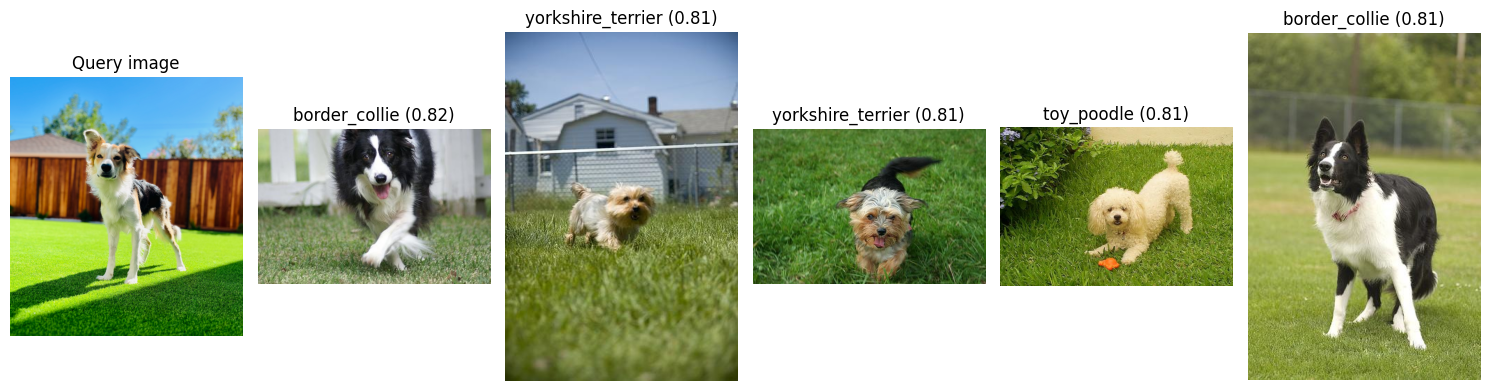

(autoscaler +4m50s) [autoscaler] Downscaling node i-06e7a611d84d3f02a (node IP: 10.0.132.59) due to node idle termination.
(autoscaler +4m55s) [autoscaler] Cluster resized to {56 CPU, 4 GPU}.


In [ ]:
# Top matches by embedding similarity.
embeddings_ds = ray.data.read_parquet(embeddings_path)
top_matches = get_top_matches(embedding, embeddings_ds, n=5)
display_top_matches(url, top_matches)